In [2]:
import librosa as librosa
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
import librosa.display
from tqdm.notebook import tqdm
import warnings  
warnings.filterwarnings('ignore') # Librosa's specshow gives warnings about a matplotlib deprecation thing

In [3]:


import os
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = 'CPU'

In [4]:
# !pip install librosa

In [5]:
# !pip install torch==1.13.1+cu111 -f https://download.pytorch.org/whl/cu111/torch_stable.html


In [6]:

!pip install -U torch torchaudio --no-cache-dir

In [7]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio


In [8]:
 # !pip install librosa

In [9]:
def chunk_to_spec(chunk, SPEC_HEIGHT=64,SPEC_WIDTH=256, rate=32000, FMIN=200, FMAX=12500):
    mel_spec = librosa.feature.melspectrogram(y=chunk, 
                                              sr=32000, 
                                              n_fft=1024, 
                                              hop_length=int(32000 * 5 / (SPEC_WIDTH - 1)), 
                                              n_mels=SPEC_HEIGHT, 
                                              fmin=FMIN, 
                                              fmax=FMAX)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

In [10]:
df = pd.read_csv('info_df.csv')
print(df.shape)
df.head(3)

(14852, 4)


,fn,len,label,peaks
0,train_audio/oahama/XC511591.ogg,612864,oahama,4.224#16.06#5.072#3.280#1.248#9.040#17.74#12.8...
1,train_audio/oahama/XC27358.ogg,152137,oahama,2.801#0.512#0.512#0.512#0.512#0.512#0.512#0.51...
2,train_audio/oahama/XC454888.ogg,2002860,oahama,41.86#41.04#33.09#19.14#37.57#1.552#27.06#2.36...


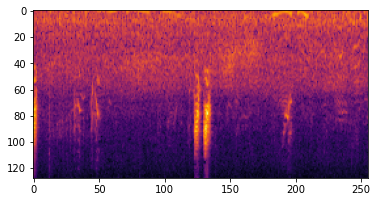

In [11]:
fn, l, y, peaks = df.sample().values[0]
start_time = min(l/32000 - 5, max(float(peaks.split('#')[0])-2.5, 2.5))
y, sr = librosa.load(fn, sr=32000, offset=start_time, duration=5)
plt.imshow(chunk_to_spec(y, SPEC_HEIGHT=128), cmap='inferno')

In [12]:
# !pip install torchaudio
from fastai.vision.all import *
import librosa as librosa
import torchvision.transforms as T


In [13]:
# !pip install fastai

train and val size 11882 2970
torch.Size([16, 3, 112, 224])


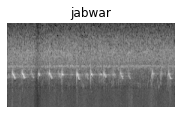

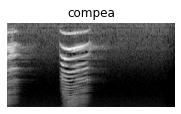

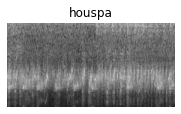

In [14]:
class TitledImage(fastuple):
    def show(self, ctx=None, **kwargs): show_titled_image(self, ctx=ctx, **kwargs)

class ClipTransform(ItemTransform):

    def __init__(self, df):
        self.df=df
        self.vocab,self.o2i = uniqueify(df['label'], sort=True, bidir=True)
        
    def encodes(self, i, from_np=False):
        f, l, label, peaks = df.iloc[i].values
        clip_num = random.choice([0, 0, 0, 1, 1, 2, 3, 4, 5, 6]) # More prob chose big peak
        start_time = min(l/32000 - 5, max(float(peaks.split('#')[clip_num])-2.5, 2.5))
        y, sr = librosa.load(f, sr=32000, offset=start_time, duration=5)
        spec = chunk_to_spec(y,SPEC_HEIGHT=112,SPEC_WIDTH=224)
        spec.resize(112,224)
        spec -= np.min(spec) 
        spec /= 80 # np.max(spec) # Normalize
        spec =  torch.unsqueeze(tensor(spec), 0)
        spec = torch.cat([spec, spec, spec]) # Stack three channels to simulate RGB if using a pretrained model
        return spec, self.o2i[label]
    
    def decodes(self, x):
        return TitledImage(x[0],self.vocab[x[1]])


df_small = df
clip_tfm = ClipTransform(df)
train =  df_small.sample(frac=0.8)
train_idx, valid_idx = list(train.index), df_small[~df_small.index.isin(train.index)].index
print('train and val size', len(train_idx), len(valid_idx))
train_tl= TfmdLists(train_idx, clip_tfm)
valid_tl= TfmdLists(valid_idx, clip_tfm)
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=16,num_workers=1)
# dls = dls.cuda(nu)
xb, yb = dls.one_batch()
print(xb.shape)
dls.show_batch(max_n=3)

In [15]:
learn = cnn_learner(dls, models.alexnet, loss_func=FocalLossFlat(), metrics=[accuracy], cbs=[ShowGraphCallback(), CSVLogger()])

epoch,train_loss,valid_loss,accuracy,time
0,5.481113,5.091903,0.130303,12:14
1,4.443738,3.670785,0.241751,12:55
2,3.698850,6.123579,0.205387,13:10
3,3.216746,3.825944,0.169360,13:29
4,3.021611,3.440499,0.289899,13:42
5,2.585285,2.342475,0.402694,14:02
6,2.371121,2.365074,0.418855,13:56
7,2.250017,2.182292,0.473064,14:21
8,2.008005,1.954255,0.526263,13:55


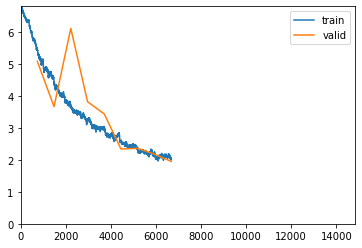

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-4, 1e-3))

In [ ]:
learn.recorder.plot_loss()
plt.savefig('loss_plot2.png')

In [ ]:
learn.save('stage-1')


In [ ]:
learn.remove_cb(CSVLogger) # Not pickleable
learn.export('baseline_3eee.pkl')